Illiquid Asset Volume Trends
### By performing these quantitative analyses on asset volume data, traders and analysts can gain insights into market liquidity and trading patterns, helping to identify more opportune times for executing large trades in illiquid assets, thereby potentially minimizing market impact and cost basis.

#### Data Loading 

In [2]:
#load libraries and dependencies 

import alpaca_trade_api as tradeapi
import plotly.express as px
from dotenv import load_dotenv
from pathlib import Path
import datetime as dt
import plotly as pl 
import pandas as pd
import numpy as np
import requests
import json
import os
import csv

In [3]:
#env variables
load_dotenv('api_keys.env')
api_key = os.getenv('ALPACA_API_KEY')
secret_key = os.getenv('ALPACA_SECRET_KEY')

In [4]:
#REST object api
api = tradeapi.REST(
    api_key,
    secret_key,
    api_version='v2'
)

#initiate requests variables 
ticker = 'TSLA'
timeframe = '1D'
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2024-01-01', tz='America/New_York').isoformat()

#alpaca api bars request
df = api.get_bars(
    ticker,
    timeframe,
    start=start_date,
    end=end_date
).df

#PREPROCESS DATA

#clean and reindex
df.dropna()
df.index = df.index.date
df.index.name = 'date'
df.reset_index(inplace=True)
df.rename_axis(index={'Letter': 'NewLetter'}, inplace=True)

# #set daily, monthly and yearly columns
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day_name()
df['week'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month_name()
df['year'] = df['date'].dt.year

#drop unecessary columns
data = df.drop(columns=['open', 'high', 'low', 'trade_count', 'vwap'])
data = df.set_index('date', inplace=True)
data = df.reindex(columns=['week', 'year', 'month', 'day', 'volume', 'close'])

#print dataframe
data.head()

,week,year,month,day,volume,close
date,,,,,,
2019-01-02,1,2019,January,Wednesday,11836650,310.12
2019-01-03,1,2019,January,Thursday,7087451,300.36
2019-01-04,1,2019,January,Friday,7538704,317.69
2019-01-07,2,2019,January,Monday,7660432,334.96
2019-01-08,2,2019,January,Tuesday,7212138,335.35


### Data Preprocessing

In [5]:
#separate data for possible future calculations
data.index = pd.to_datetime(data.index)
daily_close_df = pd.DataFrame(data['close'])
daily_volume_df = pd.DataFrame(data['volume'])

#volume highs and lows 
weekly_vol = data['volume'].resample('W').agg(['max', 'min'])
monthly_vol = data['volume'].resample('M').agg(['max', 'min'])
yearly_vol = data['volume'].resample('A').agg(['max', 'min'])


#print
    #daily_close_df
    #daily_volume_df

    
# Convert weekly high/low volumes to a list 
weekly_high_volumes = weekly_vol['max'].tolist()
weekly_low_volumes = weekly_vol['min'].tolist()

# Define function that labels the volume
def label_volume(row):
    if row['volume'] in weekly_high_volumes:
        return 'high'
    elif row['volume'] in weekly_low_volumes:
        return 'low'
    else:
        return 'unknown'

# Apply function to original dataframe
data['Label'] = data.apply(label_volume, axis=1)

#set weekly days as new dataframe
weekly_days = data[data['Label'].isin(['high', 'low'])]
print(f'Weekly Volume')
display(weekly_days.head()) 

######################################################

# Convert monthly high/low volumes to a list 
monthly_high_volumes = monthly_vol['max'].tolist()
monthly_low_volumes = monthly_vol['min'].tolist()

# Define function that labels the volume
def label_volume(row):
    if row['volume'] in monthly_high_volumes:
        return 'high'
    elif row['volume'] in monthly_low_volumes:
        return 'low'
    else:
        return 'unknown'

# Apply function to original dataframe
data['Label'] = data.apply(label_volume, axis=1)

#set monthly days selection as new dataframe
monthly_days = data[data['Label'].isin(['high', 'low'])]
print(f'Monthly Volume')
display(monthly_days.head())

#######################################################

# Convert yearly high/low volumes to a list 
yearly_high_volumes = yearly_vol['max'].tolist()
yearly_low_volumes = yearly_vol['min'].tolist()

# Define function that labels the volume
def label_volume(row):
    if row['volume'] in yearly_high_volumes:
        return 'high'
    elif row['volume'] in yearly_low_volumes:
        return 'low'
    else:
        return 'unknown'

# Apply function to original dataframe
data['Label'] = data.apply(label_volume, axis=1)

#set weekly days selection as new dataframe
yearly_days = data[data['Label'].isin(['high', 'low'])]
print(f'Yearly Volume')
display(yearly_days.head())

Weekly Volume


,week,year,month,day,volume,close,Label
date,,,,,,,
2019-01-02,1,2019,January,Wednesday,11836650,310.12,high
2019-01-03,1,2019,January,Thursday,7087451,300.36,low
2019-01-07,2,2019,January,Monday,7660432,334.96,high
2019-01-11,2,2019,January,Friday,5127247,347.26,low
2019-01-17,3,2019,January,Thursday,3766877,347.31,low


Monthly Volume


,week,year,month,day,volume,close,Label
date,,,,,,,
2019-01-17,3,2019,January,Thursday,3766877,347.31,low
2019-01-18,3,2019,January,Friday,24359859,302.26,high
2019-02-15,7,2019,February,Friday,4009317,307.88,low
2019-02-27,9,2019,February,Wednesday,11307356,314.74,high
2019-03-01,9,2019,March,Friday,23064224,294.79,high


Yearly Volume


,week,year,month,day,volume,close,Label
date,,,,,,,
2019-10-24,43,2019,October,Thursday,30428851,299.68,high
2019-11-29,48,2019,November,Friday,2565414,329.94,low
2020-08-05,32,2020,August,Wednesday,5054464,1485.02,low
2020-12-18,51,2020,December,Friday,300234026,658.34,high
2021-03-05,9,2021,March,Friday,90222134,597.95,high


### Plot 

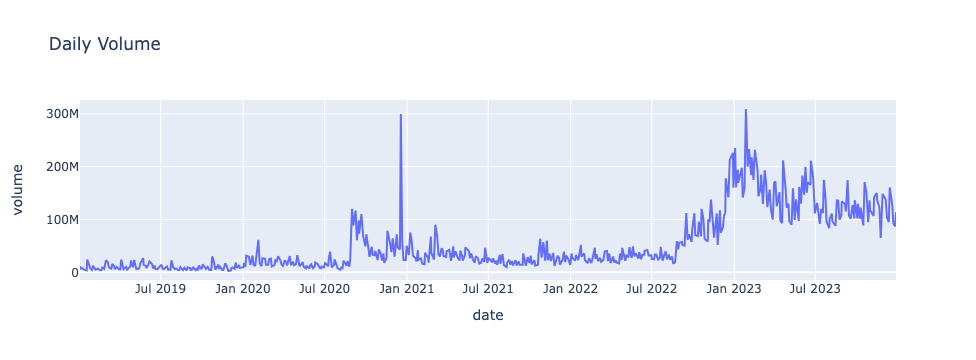

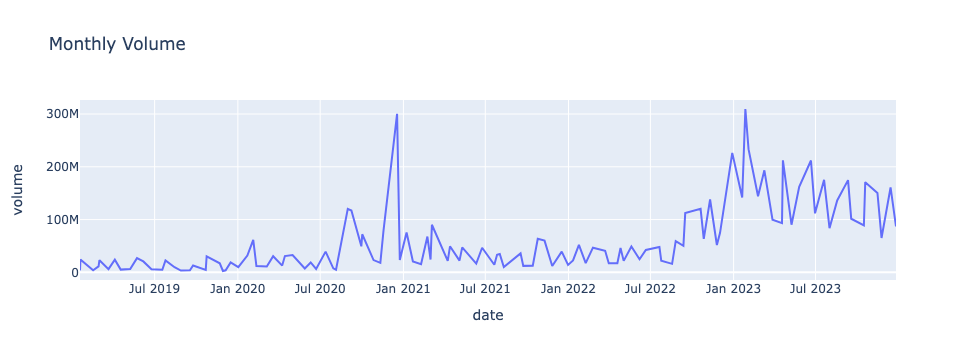

In [7]:
import plotly.express as px

#weekly plot
fig_weekly = px.line(
    weekly_days,
    x= weekly_days.index,
    y= 'volume',
    title='Daily Volume')

#monthly plot
fig_monthly = px.line(
    monthly_days,
    x=monthly_days.index,
    y='volume',
    title='Monthly Volume')

#yearly plot
#fig_yearly = px.line(yearly_days, x=yearly_days.index,y='volume',title='Yearly Volume')

fig_weekly.show()
fig_monthly.show()
#fig_yearly.show()

In [8]:
#high and low frequencies for days of the week
high_days = weekly_days[weekly_days['Label'] == 'high'].groupby('day').size() 
low_days = weekly_days[weekly_days['Label'] == 'low'].groupby('day').size()

#sort frequencies for days of the week
high_days_data = high_days.sort_values(ascending=False)
low_days_data = low_days.sort_values(ascending=True)

#print(f'High Days {high_days_data}')
#print()
#print(f'Low Days {low_days_data}')

<Axes: title={'center': 'High Day Frequency - Past 5 Years'}, xlabel='Day of the Week', ylabel='Number of Days'>

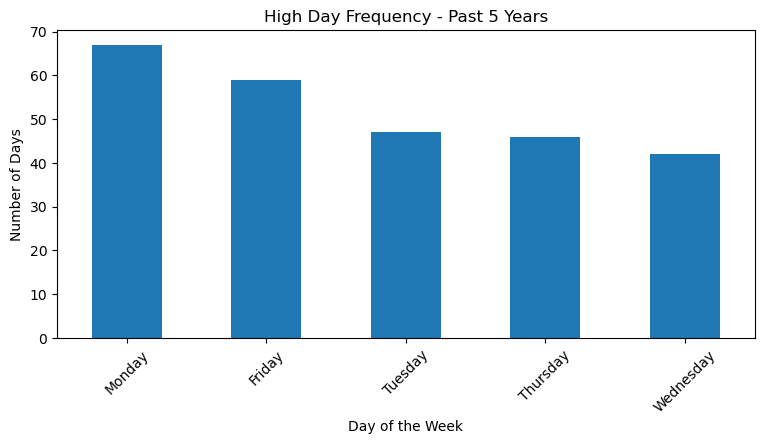

In [14]:
high_days_data.plot.bar(
    x='key',
    y='# of high days',
    xlabel='Day of the Week',
    ylabel='Number of Days',
    rot=45,
    figsize=(9,4),
    title='High Day Frequency - Past 5 Years')

<Axes: title={'center': 'Low Day Frequency - Past 5 Years'}, xlabel='day'>

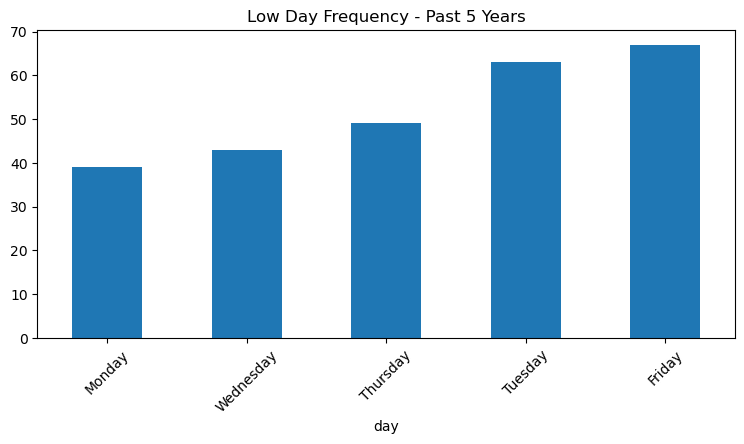

In [15]:
low_days_data.plot.bar(
    x='day',
    y='# of days',
    rot=45,
    figsize=(9,4),
    title='Low Day Frequency - Past 5 Years')

In [526]:
#find the top 5 daily volume traded
sorted_data= data.sort_values(by='volume', ascending=False)
top_5_df = sorted_data.head()
top_5_df

,week,year,month,day,volume,close,Label
date,,,,,,,
2023-01-27,4,2023,January,Friday,309508609,177.90,high
2020-12-18,51,2020,December,Friday,300234026,658.34,high
2023-01-26,4,2023,January,Thursday,238806737,160.27,unknown
2023-01-03,1,2023,January,Tuesday,235727017,108.10,unknown
2023-02-03,5,2023,February,Friday,233445345,189.98,unknown


### Trade Data

In [72]:
#request trade data for day 1
#ticker = 'TSLA'
#start_date= pd.Timestamp('2023-01-27', tz='America/New_York').isoformat()
#end_date= pd.Timestamp('2023-01-28', tz='America/New_York').isoformat()

#day_1 = api.get_trades(ticker,start_date,end_date).df


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying h

In [80]:
#day_1 = day_1.drop(columns=['conditions', 'id', 'exchange', 'tape'])
file_name = '../School/Project_1/day_1.csv'
day_1.to_csv(file_name, index=True)

In [43]:
#day 2 trade data 

#start_date = pd.Timestamp('2020-12-18', tz ='America/New_York').isoformat()
#end_date = pd.Timestamp('2020-12-19', tz ='America/New_York').isoformat() 

#trade_data_day_2 = api.get_trades(ticker,start_date,end_date).df

sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying h

In [81]:
#day_2 = trade_data_day_2.drop(columns=['conditions', 'id', 'exchange', 'tape'])
file_name = '../School/Project_1/day_2.csv'
day_2.to_csv(file_name, index=True)

In [45]:
#day 3 trade data

#start_date = pd.Timestamp('2023-01-26', tz ='America/New_York').isoformat()
#end_date = pd.Timestamp('2023-01-27', tz ='America/New_York').isoformat()

#trade_data_day_3 = api.get_trades(ticker,start_date,end_date).df

sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying h

In [82]:
#day_3 = trade_data_day_3.drop(columns=['conditions', 'id', 'exchange', 'tape'])
file_name = '../School/Project_1/day_3.csv'
day_3.to_csv(file_name, index=True)

In [47]:
#day 4 trade data 

#start_date = pd.Timestamp('2023-01-03', tz ='America/New_York').isoformat()
#end_date = pd.Timestamp('2023-01-04', tz ='America/New_York').isoformat()
    
#trade_data_day_4 = api.get_trades(ticker,start_date,end_date).df

sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying h

In [83]:
#day_4 = trade_data_day_4.drop(columns=['conditions', 'id', 'exchange', 'tape'])
file_name = '../School/Project_1/day_4.csv'
day_4.to_csv(file_name, index=True)

In [53]:
#day 5 trade data 

#start_date = pd.Timestamp('2023-02-03', tz ='America/New_York').isoformat()
#end_date = pd.Timestamp('2023-02-04', tz ='America/New_York').isoformat()
    
#trade_data_day_5 = api.get_trades(ticker,start_date,end_date).df

sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TSLA/trades 3 more time(s)...
sleep 3 seconds and retrying h

In [331]:
#day_5 = trade_data_day_5.drop(columns=['conditions', 'id', 'exchange', 'tape'])
file_name = '../School/Project_1/day_5.csv'
day_5.to_csv(file_name, index=True)

## Kyles Lambda 

### Kyles(λ) = ∑(Price×Size) / ∑(Size^2)

### Day 1

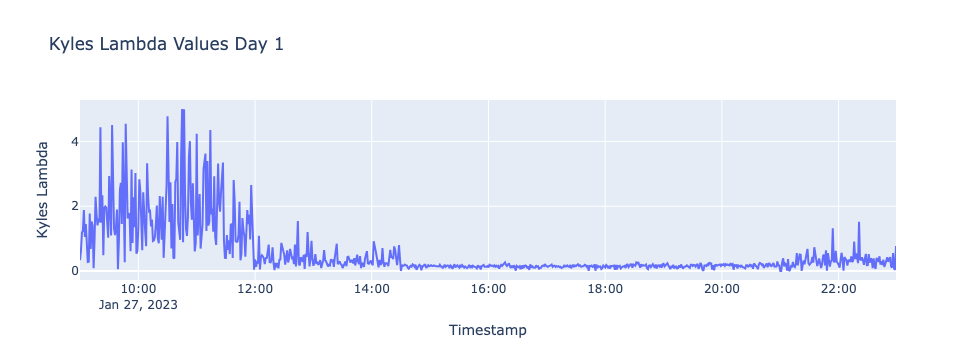

In [364]:
#DAY 1
df_day_1 = pd.read_csv('../School/Project_1/day_1.csv')
df_day_1['timestamp'] = pd.to_datetime(df_day_1['timestamp'], format='mixed')
df_day_1.set_index('timestamp', inplace=True)

#group by 1 min and calculate lambda  
df_resampled = df_day_1.resample('T')
df = df_resampled.apply(lambda df: (df['price'] * df['size']).sum() / (df['size']**2).sum())

#reindex results in new dataframe 
lambda_1 = df.reset_index().rename(columns={0: 'lambda'})
#display(lambda_1.head())

#plot day 1
fig = px.line(lambda_1, x='timestamp', y='lambda',
              labels={'timestamp': 'Timestamp', 'lambda': 'Kyles Lambda'}, 
              title='Kyles Lambda Values Day 1')
fig.show()

### Day 2

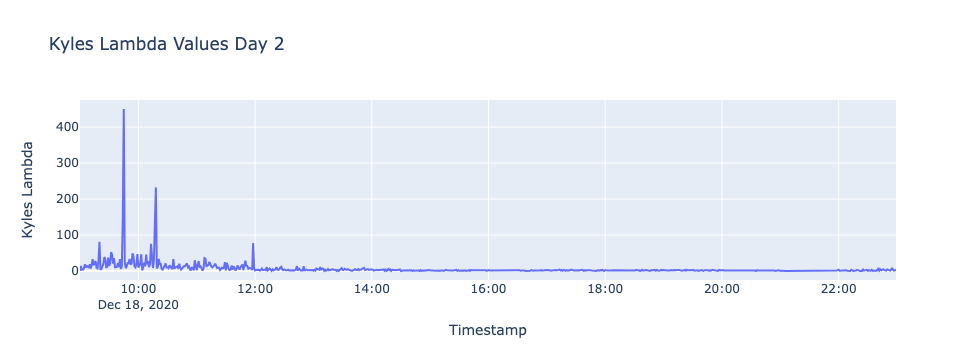

In [517]:
#DAY 2
df_day_2 = pd.read_csv('../School/Project_1/day_2.csv')
df_day_2['timestamp'] = pd.to_datetime(df_day_2['timestamp'], format='mixed')
df_day_2.set_index('timestamp', inplace=True)

#group by 1 min and calculate lambda  
df_resampled = df_day_2.resample('T')
df = df_resampled.apply(lambda df: (df['price'] * df['size']).sum() / (df['size']**2).sum())

#reindex results in new dataframe 
lambda_2 = df.reset_index().rename(columns={0: 'lambda'})
#lambda_2.head()

#plot day 2
fig = px.line(lambda_2, x='timestamp', y='lambda',
              labels={'timestamp': 'Timestamp', 'lambda': 'Kyles Lambda'}, 
              title='Kyles Lambda Values Day 2')
fig.show()

### Day 3

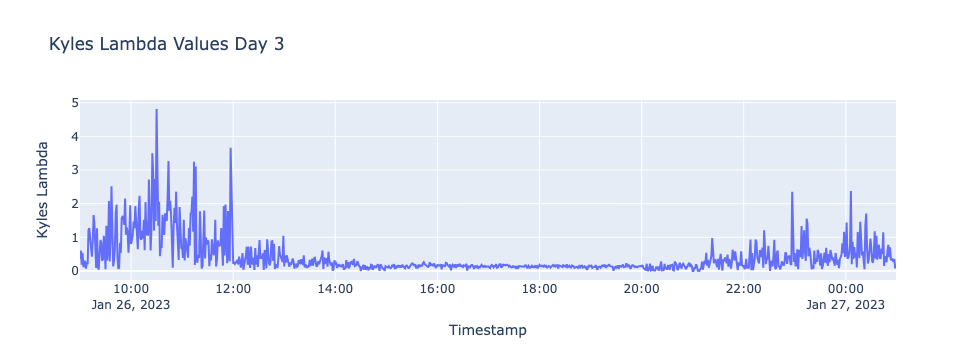

In [366]:
#DAY 3
df_day_3 = pd.read_csv('../School/Project_1/day_3.csv')
df_day_3['timestamp'] = pd.to_datetime(df_day_3['timestamp'], format='mixed')
df_day_3.set_index('timestamp', inplace=True)

#group by 1 min and calculate lambda  
df_resampled = df_day_3.resample('T')
df = df_resampled.apply(lambda df: (df['price'] * df['size']).sum() / (df['size']**2).sum())

#reindex results in new dataframe 
lambda_3 = df.reset_index().rename(columns={0: 'lambda'})
#lambda_2.head()

#plot day 3
fig = px.line(lambda_3, x='timestamp', y='lambda',
              labels={'timestamp': 'Timestamp', 'lambda': 'Kyles Lambda'}, 
              title='Kyles Lambda Values Day 3')
fig.show()

### Day 4

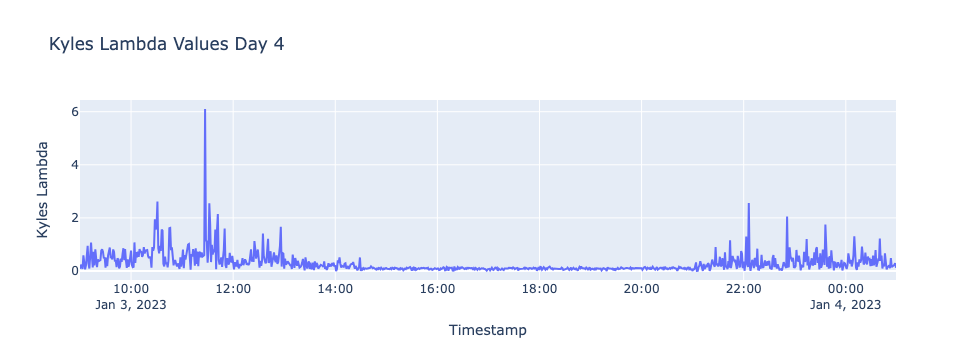

In [367]:
#DAY 4
df_day_4 = pd.read_csv('../School/Project_1/day_4.csv')
df_day_4['timestamp'] = pd.to_datetime(df_day_4['timestamp'], format='mixed')
df_day_4.set_index('timestamp', inplace=True)

#group by 1 min and calculate lambda  
df_resampled = df_day_4.resample('T')
df = df_resampled.apply(lambda df: (df['price'] * df['size']).sum() / (df['size']**2).sum())

#reindex results in new dataframe 
lambda_4 = df.reset_index().rename(columns={0: 'lambda'})
#lambda_2.head()

#plot day 4
fig = px.line(lambda_4, x='timestamp', y='lambda',
              labels={'timestamp': 'Timestamp', 'lambda': 'Kyles Lambda'}, 
              title='Kyles Lambda Values Day 4')
fig.show()

### Day 5

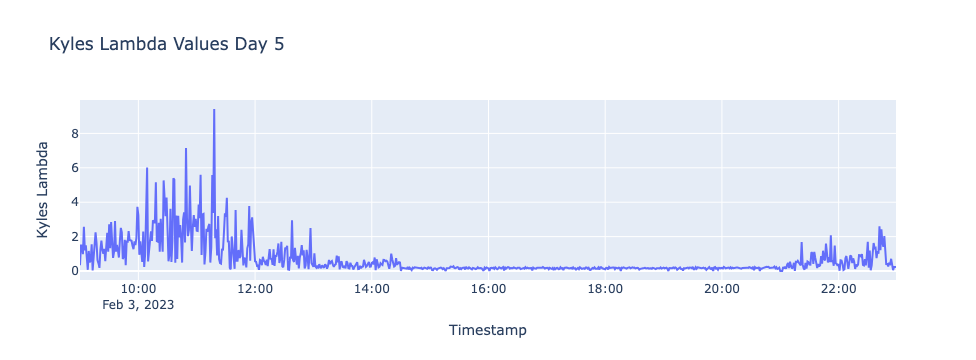

In [16]:
#DAY 5
df_day_5 = pd.read_csv('../School/Project_1/day_5.csv')
df_day_5['timestamp'] = pd.to_datetime(df_day_5['timestamp'], format='mixed')
df_day_5.set_index('timestamp', inplace=True)

#group by 1 min and calculate lambda  
df_resampled = df_day_5.resample('T')
df = df_resampled.apply(lambda df: (df['price'] * df['size']).sum() / (df['size']**2).sum())

#reindex results in new dataframe 
lambda_5 = df.reset_index().rename(columns={0: 'lambda'})
#lambda_5.head()

#plot day 5
fig = px.line(lambda_5, x='timestamp', y='lambda',
              labels={'timestamp': 'Timestamp', 'lambda': 'Kyles Lambda'}, 
              title='Kyles Lambda Values Day 5')
fig.show()